# Detecção de fraude - cartão de crédito - Kaggle

## Introdução

Este notebook utiliza base de dados do Kaggle:
- https://www.kaggle.com/dalpozz/creditcardfraud

A base de dados contém mais de 284 mil transações de cartão de crédito contendo hora, valor e
28 atributos normalizados obtidos através de transformação PCA de redução de dimensionalidade.
Assim, ao todo são 30 atributos. O alvo do problema é prever se a transação é fraudulenta ou
genuína.
Uma característica fundamental deste dataset e que é comum em sistemas de fraudes é a diferença
entre respostas positivas: 284315 versus respostas negativas fraudulentas: 492. As fraudes 
representam apenas 0,17% das transações.
Este problema pode ser visto como sendo um problema de detecção de anomalia, entretanto iremos
tratá-la como um problema de classificação em duas classes utilizando redes neurais com
várias técnicas de regularização.

## Importação

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import os,sys
import time
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

#from torchvision import datasets, transforms, models

import sklearn.metrics

import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Leitura dos dados

In [2]:
dataframe = pd.read_csv('/data/datasets/creditcard.csv', header=0)
print('dataframe.shape:',dataframe.shape)
dataframe.head()

dataframe.shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Número de amostras legítimas e fraudulentas

In [3]:
target = np.asarray(dataframe['Class'])
n_samples = target.shape[0]
print('n. de amostras:', n_samples)
print('transações legítimas:', (target==0).sum())
print('transações fraudulentas:', (target==1).sum())

n. de amostras: 284807
transações legítimas: 284315
transações fraudulentas: 492


### Aplica mod no Timestamp para ser uma indicação da hora diária e normaliza dados 

In [4]:
df_cp = dataframe.copy()
inputs = np.asarray(df_cp.values)[:,:-1]
timestamp = inputs[:,0]
timestamp = timestamp % (60* 60 * 24) # modulo número de segundos por dia
inputs -= inputs.min(axis=0)
inputs /= inputs.max(axis=0)
inputs[:1],inputs.shape  # dados de uma amostra normalizada

(array([[ 0.        ,  0.93519234,  0.76649042,  0.8813649 ,  0.31302266,
          0.76343873,  0.26766864,  0.26681518,  0.7864442 ,  0.47531173,
          0.51060048,  0.25248432,  0.68090763,  0.3715906 ,  0.63559053,
          0.4460837 ,  0.43439239,  0.73717255,  0.65506586,  0.59486323,
          0.58294223,  0.56118439,  0.52299212,  0.66379298,  0.39125268,
          0.58512179,  0.39455679,  0.41897614,  0.31269663,  0.00582379]]),
 (284807, 30))

### Visualiza com boxplot

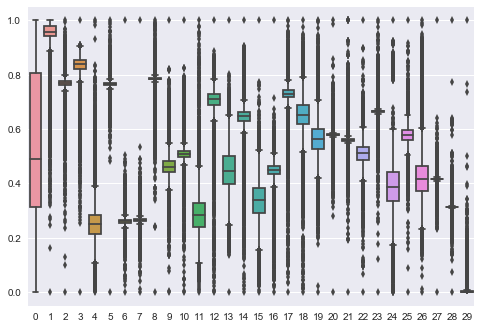

In [5]:
sns.boxplot(data=inputs[:,:]);

## Separação dados em treinamento e teste (20%)

In [6]:
iv = int(0.2 * inputs.shape[0])
xt_train = torch.from_numpy(inputs[iv:]).type(torch.FloatTensor)
yt_train = torch.from_numpy( target[iv:])
xt_valid = torch.from_numpy(inputs[:iv]).type(torch.FloatTensor)
yt_valid = torch.from_numpy( target[:iv])


In [7]:
FEATURE_NUM = 30
CLASSES = 2

## Definição da rede

In [8]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        #self.bn1   = nn.BatchNorm1d(FEATURE_NUM)
        self.ln1   = nn.Linear(FEATURE_NUM,100)
        #self.bn2   = nn.BatchNorm1d(100, momentum=0.01)
        self.ln2   = nn.Linear(100,100)
        self.ln3   = nn.Linear(100,50)
        self.ln4   = nn.Linear(50,CLASSES)

    def forward(self, x):
        #x = self.bn1(x)         # (FEATURE_NUM,FEATURE_NUM)
        
        x = self.ln1(x)         # (FEATURE_NUM,100)
        x = F.relu(x)
        x = F.dropout(x,0.5)  
        #x = self.bn2(x)         # (100,100)
        
        x = self.ln2(x)         # (100,100)
        x = F.relu(x)
        x = F.dropout(x,0.5)
        
        x = self.ln3(x)         # (100,50)
        x = F.relu(x)
        x = F.dropout(x,0.5)
        
        x = self.ln4(x)         # (50,2)
        return x

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.ln1   = nn.Linear(FEATURE_NUM,100)
        self.do1   = nn.AlphaDropout(0.3)
        self.ln2   = nn.Linear(100,100)
        self.do2   = nn.AlphaDropout(0.3)
        self.ln2_1   = nn.Linear(100,100)
        self.do2_1   = nn.AlphaDropout(0.3)
        self.ln2_2   = nn.Linear(100,100)
        self.do2_2   = nn.AlphaDropout(0.3)
        self.ln3   = nn.Linear(100,50)
        self.do3   = nn.AlphaDropout(0.3)
        self.ln4   = nn.Linear(50,CLASSES)

    def forward(self, x):
        
        x = self.ln1(x)         # (FEATURE_NUM,100)
        x = F.selu(x)
        x = self.do1(x)  
        
        x = self.ln2(x)         # (100,100)
        x = F.selu(x)
        x = self.do2(x)
        
        x = self.ln2_1(x)         # (100,100)
        x = F.selu(x)
        x = self.do2_1(x)
 
        x = self.ln2_2(x)         # (100,100)
        x = F.selu(x)
        x = self.do2_2(x)
 
        x = self.ln3(x)         # (100,50)
        x = F.selu(x)
        x = self.do3(x)
        
        x = self.ln4(x)         # (50,2)
        return x

model = Model2()
if use_gpu:
    model.cuda()
model

Model2(
  (ln1): Linear(in_features=30, out_features=100)
  (ln2): Linear(in_features=100, out_features=100)
  (ln3): Linear(in_features=100, out_features=50)
  (ln4): Linear(in_features=50, out_features=2)
)

## Testando um predict

In [9]:
if use_gpu:
    y = model(Variable(xt_train[0:3]).cuda())
else:
    y = model(Variable(xt_train[0:3]))
print(y)
print(F.softmax(y,dim=1))

Variable containing:
-0.0451  0.1200
-0.0438  0.1177
-0.0456  0.1215
[torch.FloatTensor of size 3x2]

Variable containing:
 0.4588  0.5412
 0.4597  0.5403
 0.4583  0.5417
[torch.FloatTensor of size 3x2]



## Treinamento

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)
criterion = nn.CrossEntropyLoss()
savebest  = ptt.ModelCheckpoint('../../models/creditcardfraud_pt',reset=True,verbose=1)
trainer = ptt.DeepNetTrainer(
        model =         model,
        criterion =     criterion,
        optimizer =     optimizer,
        lr_scheduler =  scheduler,
        callbacks =     [savebest, ptt.PrintCallback()],
        )

In [11]:
batch_size = 1000 # A escolha do batch_size é crítica pois se batch_size for pequeno, só treina com legítimos
trainer.fit(10, xt_train, yt_train, valid_data=(xt_valid,yt_valid), batch_size=batch_size)


Start training for 10 epochs
  1:   3.1s   T: 0.02511   V: 0.00602 best
  2:   2.9s   T: 0.00476   V: 0.00518 best
  3:   2.9s   T: 0.00371   V: 0.00509 best
  4:   3.1s   T: 0.00409   V: 0.00486 best
  5:   3.1s   T: 0.00347   V: 0.00500 
  6:   3.1s   T: 0.00333   V: 0.00579 
  7:   3.0s   T: 0.00349   V: 0.00462 best
  8:   3.1s   T: 0.00333   V: 0.00591 
  9:   3.0s   T: 0.00346   V: 0.00514 
 10:   3.2s   T: 0.00335   V: 0.00542 
Best model was saved at epoch 7 with loss 0.00462: ../../models/creditcardfraud_pt
Stop training at epoch: 10/10


## Avaliação


<table border="1px">
<tr>
    <th> </th> <th> </th> <th colspan="2">Dataset</th>
</tr><tr>
    <th> </th> <th> </th>                                 <th>Legítima (0)</th> <th>Fraude (1)</th>
</tr><tr>
<th rowspan="4">Detecção </th> <th rowspan="2"> Negativo (0)  </th> <th>VN   </th> <th>FN</th>
</tr><tr>
                                                      <th>(legítima correta)</th> <th>(fraude não detectada)</th>
</tr><tr>
                               <th rowspan="2"> Positivo (1)  </th> <th>FP   </th> <th>VP</th>
</tr><tr>
                                                          <th>(alarme falso)   </th> <th>(fraude detectada)</th>
</tr>
</table>

- Amostras: $M = VP+VN+FP+FN$
- Acurácia ou Exatidão: $ACC = \frac{VP+VN}{M} $ Detecções corretas sobre o total
- Precisão: $P  = \frac{VP}{VP+FP}$ Taxa de fraudes detectadas são realmente fraudes (não quer perder vendas)
- Sensibilidade:$S  = \frac{VP}{VP+FN} $ Capacidade de detectar todas as fraudes (não quer perder dinheiro)

In [12]:
trainer.load_state('../../models/creditcardfraud_pt')

In [13]:
y_pred = trainer.predict_classes(xt_train)

In [14]:
def confmatrix_prec_recall(y,y_pred):
    ''' Compute Confusion Matrix, Precision and Recall'''
    n = len(y)
    assert n == len(y_pred)
    xy = y_pred + 2* y
    cm = np.bincount(xy,minlength=4)
    precision = cm[3]/(cm[3]+cm[1]+sys.float_info.epsilon)
    recall = cm[3]/(cm[3]+cm[2]+sys.float_info.epsilon)
    return cm.reshape(2,2), precision, recall


In [15]:
cm,p,r = confmatrix_prec_recall(y_pred.cpu().numpy(),yt_train.numpy())
cm

array([[227496,    112],
       [    15,    223]])

In [16]:
metrics = trainer.evaluate(xt_train,yt_train)
print('Treinamento:',metrics)

evaluate: 22784/22784 ok
Treinamento: {'losses': 0.003252776906288671}


In [17]:
metrics = trainer.evaluate(xt_valid,yt_valid)
print('Validação:',metrics)

evaluate: 5696/5696 ok
Validação: {'losses': 0.0046192073374337886}


In [18]:
y_pred = trainer.predict_classes(xt_valid)
cm,p,r = confmatrix_prec_recall(y_pred.cpu().numpy(),yt_valid.numpy())
cm

array([[56768,    24],
       [   36,   133]])

In [19]:
lt = trainer.metrics['train']['losses'][-1]
lv = trainer.metrics['valid']['losses'][-1]
print('{:.5f} {:.5f}'.format(lt, lv) )

0.00349 0.00462


## Aprendizados